# Stock Selection Strategy - April & May 2016 Analysis

## Strategy Overview

1. **April Selection**: Select Top 10 and Top 25 stocks based on first week performance (Days 1-7)
2. **April Performance**: Track full month returns (Day 1 to last trading day)
3. **May First Week**: Calculate first week performance (Days 1-7)
4. **Combined Scoring**: 50% April full month return + 50% May first week return
5. **May 8 - June 7 Tracking**: Monitor daily returns from calendar May 8 to June 7


In [3]:
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [5]:
# Function: Load and prepare data
def load_data(file_path):
    """Load OHLC data and prepare it for analysis"""
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['open'] > 0) & (df['close'] > 0)].sort_values(['date', 'symbol']).reset_index(drop=True)
    df.rename(columns={'symbol': 'ticker'}, inplace=True)
    return df

print("✅ Function: load_data() defined")


✅ Function: load_data() defined


In [6]:
# Function: Calculate first week performance
def get_first_week_performance(daily_df, year, month):
    """
    Calculate performance for first 7 trading days of a specific month
    Returns: DataFrame with ticker and first_week_return
    """
    month_data = daily_df[(daily_df['date'].dt.year == year) & 
                          (daily_df['date'].dt.month == month)].copy()
    
    if len(month_data) == 0:
        return pd.DataFrame(columns=['ticker', 'first_week_return'])
    
    # Get unique trading dates and take first 7
    trading_days = sorted(month_data['date'].unique())
    if len(trading_days) < 7:
        first_week_days = trading_days
    else:
        first_week_days = trading_days[:7]
    
    # Get opening price from first day
    first_day_data = month_data[month_data['date'] == first_week_days[0]][['ticker', 'open']]
    first_day_data.columns = ['ticker', 'start_open']
    
    # Get closing price from 7th day (or last available)
    last_day_data = month_data[month_data['date'] == first_week_days[-1]][['ticker', 'close']]
    last_day_data.columns = ['ticker', 'end_close']
    
    # Calculate first week performance
    merged = first_day_data.merge(last_day_data, on='ticker')
    merged['first_week_return'] = ((merged['end_close'] - merged['start_open']) / merged['start_open']) * 100
    
    return merged[['ticker', 'first_week_return']].sort_values('first_week_return', ascending=False)

print("✅ Function: get_first_week_performance() defined")


✅ Function: get_first_week_performance() defined


In [7]:
# Function: Calculate full month performance
def get_full_month_performance(daily_df, year, month):
    """
    Calculate performance for entire month (Day 1 to last trading day)
    Returns: DataFrame with ticker and full_month_return
    """
    month_data = daily_df[(daily_df['date'].dt.year == year) & 
                          (daily_df['date'].dt.month == month)].copy()
    
    if len(month_data) == 0:
        return pd.DataFrame(columns=['ticker', 'full_month_return'])
    
    # Get all trading days in the month
    trading_days = sorted(month_data['date'].unique())
    first_day = trading_days[0]
    last_day = trading_days[-1]
    
    # Get opening price from first day
    first_day_data = month_data[month_data['date'] == first_day][['ticker', 'open']]
    first_day_data.columns = ['ticker', 'start_open']
    
    # Get closing price from last day
    last_day_data = month_data[month_data['date'] == last_day][['ticker', 'close']]
    last_day_data.columns = ['ticker', 'end_close']
    
    # Calculate full month performance
    merged = first_day_data.merge(last_day_data, on='ticker')
    merged['full_month_return'] = ((merged['end_close'] - merged['start_open']) / merged['start_open']) * 100
    
    return merged[['ticker', 'full_month_return']].sort_values('full_month_return', ascending=False)

print("✅ Function: get_full_month_performance() defined")


✅ Function: get_full_month_performance() defined


In [8]:
# Function: Track daily performance
def track_daily_performance(daily_df, tickers, start_date, end_date):
    """
    Track daily cumulative returns for selected stocks from start_date to end_date
    Returns: DataFrame with dates and returns for each ticker
    """
    # Filter data for the date range
    period_data = daily_df[(daily_df['date'] >= start_date) & 
                           (daily_df['date'] <= end_date)].copy()
    
    # Get all trading days in the period
    trading_days = sorted(period_data['date'].unique())
    
    # Calculate returns for each ticker
    results = {'date': trading_days}
    
    for ticker in tickers:
        ticker_data = period_data[period_data['ticker'] == ticker].sort_values('date')
        
        if len(ticker_data) == 0:
            results[ticker] = [np.nan] * len(trading_days)
            continue
        
        # Get starting price (open on first day or closest available)
        start_price = None
        for day in trading_days:
            day_data = ticker_data[ticker_data['date'] == day]
            if len(day_data) > 0:
                start_price = day_data.iloc[0]['open']
                break
        
        if start_price is None:
            results[ticker] = [np.nan] * len(trading_days)
            continue
        
        # Calculate cumulative returns for each day
        daily_returns = []
        for day in trading_days:
            day_data = ticker_data[ticker_data['date'] == day]
            if len(day_data) > 0:
                close_price = day_data.iloc[0]['close']
                ret = ((close_price - start_price) / start_price) * 100
                daily_returns.append(ret)
            else:
                # If no data for this day, use last available return
                daily_returns.append(daily_returns[-1] if daily_returns else 0)
        
        results[ticker] = daily_returns
    
    return pd.DataFrame(results)

print("✅ Function: track_daily_performance() defined")


✅ Function: track_daily_performance() defined


## 1. Load Data


In [9]:
# Load OHLC data
print("="*100)
print("LOADING DATA")
print("="*100)

daily_df = load_data("data/nifty50_ohlc_master_complete.csv")

print(f"\n✅ Loaded {len(daily_df):,} rows of data")
print(f"   Date range: {daily_df['date'].min()} to {daily_df['date'].max()}")
print(f"   Unique tickers: {daily_df['ticker'].nunique()}")
print(f"\n   First few rows:")
print(daily_df.head())


LOADING DATA



✅ Loaded 112,432 rows of data
   Date range: 2016-04-01 00:00:00 to 2025-09-26 00:00:00
   Unique tickers: 79

   First few rows:
        date      ticker     open     high      low    close     volume  \
0 2016-04-01         ACC  1371.25  1417.00  1371.25  1413.80   353030.0   
1 2016-04-01  ADANIPORTS   248.00   248.00   239.50   242.90  1772898.0   
2 2016-04-01   AMBUJACEM   231.90   236.40   229.15   235.35  1438907.0   
3 2016-04-01  ASIANPAINT   871.00   883.95   865.00   870.00   853331.0   
4 2016-04-01    AXISBANK   440.90   452.00   440.05   449.90  8827751.0   

           isin  
0  INE012A01025  
1  INE742F01042  
2  INE079A01024  
3  INE021A01026  
4  INE238A01034  


## 2. April 2016 Analysis

### Step 1: First Week Performance (Days 1-7)
Calculate performance for the first 7 trading days to select Top 10 and Top 25 stocks


In [10]:
# Calculate April 2016 first week performance
print("="*100)
print("APRIL 2016: FIRST WEEK PERFORMANCE (Days 1-7)")
print("="*100)

april_first_week = get_first_week_performance(daily_df, 2016, 4)

print(f"\n✅ Calculated first week performance for {len(april_first_week)} stocks")
print(f"\n   Top 10 stocks by first week performance:")
print(april_first_week.head(10))

# Select Top 10 and Top 25
april_top10 = april_first_week.head(10)['ticker'].tolist()
april_top25 = april_first_week.head(25)['ticker'].tolist()

print(f"\n   Top 10: {', '.join(april_top10)}")
print(f"\n   Top 25: {', '.join(april_top25)}")


APRIL 2016: FIRST WEEK PERFORMANCE (Days 1-7)

✅ Calculated first week performance for 50 stocks

   Top 10 stocks by first week performance:
       ticker  first_week_return
8        BHEL          11.994728
0         ACC           5.535096
21   HINDALCO           5.371429
16     GRASIM           5.141695
33       NTPC           4.584305
24       IDEA           4.253394
42  TATASTEEL           4.249961
41  TATAPOWER           4.234026
30      LUPIN           2.903313
49       ZEEL           2.773437

   Top 10: BHEL, ACC, HINDALCO, GRASIM, NTPC, IDEA, TATASTEEL, TATAPOWER, LUPIN, ZEEL

   Top 25: BHEL, ACC, HINDALCO, GRASIM, NTPC, IDEA, TATASTEEL, TATAPOWER, LUPIN, ZEEL, BANKBARODA, M&M, HCLTECH, BPCL, POWERGRID, HEROMOTOCO, BAJAJ-AUTO, VEDL, ITC, DRREDDY, HDFCBANK, RELIANCE, LT, TCS, TATAMOTORS


### Step 2: Full Month Performance (Day 1 to Last Day)
Calculate returns for the entire month of April for all stocks


In [11]:
# Calculate April 2016 full month performance
print("="*100)
print("APRIL 2016: FULL MONTH PERFORMANCE (Day 1 to Last Trading Day)")
print("="*100)

april_full_month = get_full_month_performance(daily_df, 2016, 4)

print(f"\n✅ Calculated full month performance for {len(april_full_month)} stocks")
print(f"\n   Top 10 stocks by full month performance:")
print(april_full_month.head(10))

# Check how Top 10 and Top 25 performed during the full month
april_top10_performance = april_full_month[april_full_month['ticker'].isin(april_top10)]
april_top25_performance = april_full_month[april_full_month['ticker'].isin(april_top25)]

print(f"\n   Average full month return for April Top 10: {april_top10_performance['full_month_return'].mean():.2f}%")
print(f"   Average full month return for April Top 25: {april_top25_performance['full_month_return'].mean():.2f}%")

# Save April results
april_results = april_first_week.merge(april_full_month, on='ticker', how='outer')
april_results.to_csv('april_2016_performance.csv', index=False)
print(f"\n✅ Saved: april_2016_performance.csv")


APRIL 2016: FULL MONTH PERFORMANCE (Day 1 to Last Trading Day)

✅ Calculated full month performance for 50 stocks

   Top 10 stocks by full month performance:
        ticker  full_month_return
46        VEDL          15.654596
42   TATASTEEL          10.530458
31         M&M          10.296677
8         BHEL          10.193322
21    HINDALCO          10.114286
48     YESBANK           9.264195
30       LUPIN           8.899654
10        BPCL           8.666667
41   TATAPOWER           8.545035
25  INDUSINDBK           8.503595

   Average full month return for April Top 10: 8.43%
   Average full month return for April Top 25: 5.46%

✅ Saved: april_2016_performance.csv


## 3. May 2016 First Week Analysis

Calculate first week performance (Days 1-7) for May 2016


In [12]:
# Calculate May 2016 first week performance
print("="*100)
print("MAY 2016: FIRST WEEK PERFORMANCE (Days 1-7)")
print("="*100)

may_first_week = get_first_week_performance(daily_df, 2016, 5)

print(f"\n✅ Calculated first week performance for {len(may_first_week)} stocks")
print(f"\n   Top 10 stocks by first week performance:")
print(may_first_week.head(10))

# Save May first week results
may_first_week.to_csv('may_2016_first_week_performance.csv', index=False)
print(f"\n✅ Saved: may_2016_first_week_performance.csv")


MAY 2016: FIRST WEEK PERFORMANCE (Days 1-7)

✅ Calculated first week performance for 50 stocks

   Top 10 stocks by first week performance:
        ticker  first_week_return
18        HDFC          11.645059
15        GAIL           8.750000
29          LT           5.943018
3   ASIANPAINT           3.975694
16      GRASIM           3.455215
8         BHEL           2.920000
4     AXISBANK           2.867081
41   TATAPOWER           2.838893
31         M&M           2.342684
20  HEROMOTOCO           2.239889

✅ Saved: may_2016_first_week_performance.csv


## 4. Combined Scoring & Selection

### Formula: 50% April Full Month Return + 50% May First Week Return

Calculate combined scores and select Top 10 and Top 25 stocks for May tracking


In [13]:
# Calculate combined scores
print("="*100)
print("COMBINED SCORING: 50% April Full Month + 50% May First Week")
print("="*100)

# Merge April full month and May first week data
combined = april_full_month.merge(may_first_week, on='ticker', how='inner')

# Calculate combined score (50-50 weighted)
combined['combined_score'] = (combined['full_month_return'] * 0.5) + (combined['first_week_return'] * 0.5)

# Sort by combined score
combined = combined.sort_values('combined_score', ascending=False).reset_index(drop=True)

print(f"\n✅ Calculated combined scores for {len(combined)} stocks")
print(f"\n   Top 10 stocks by combined score:")
print(combined.head(10)[['ticker', 'full_month_return', 'first_week_return', 'combined_score']])

# Select Top 10 and Top 25 based on combined scores
combined_top10 = combined.head(10)['ticker'].tolist()
combined_top25 = combined.head(25)['ticker'].tolist()

print(f"\n   SELECTED Top 10: {', '.join(combined_top10)}")
print(f"\n   SELECTED Top 25 (additional 15): {', '.join([t for t in combined_top25 if t not in combined_top10])}")

# Save combined scores
combined.to_csv('may_2016_combined_scores.csv', index=False)
print(f"\n✅ Saved: may_2016_combined_scores.csv")


COMBINED SCORING: 50% April Full Month + 50% May First Week

✅ Calculated combined scores for 50 stocks

   Top 10 stocks by combined score:
       ticker  full_month_return  first_week_return  combined_score
0        VEDL          15.654596          -1.853659        6.900469
1        BHEL          10.193322           2.920000        6.556661
2         M&M          10.296677           2.342684        6.319680
3   TATAPOWER           8.545035           2.838893        5.691964
4      GRASIM           7.235634           3.455215        5.345424
5        HDFC          -1.050000          11.645059        5.297530
6        GAIL           1.607218           8.750000        5.178609
7    AXISBANK           7.144477           2.867081        5.005779
8  INDUSINDBK           8.503595           1.121764        4.812680
9     YESBANK           9.264195           0.195168        4.729681

   SELECTED Top 10: VEDL, BHEL, M&M, TATAPOWER, GRASIM, HDFC, GAIL, AXISBANK, INDUSINDBK, YESBANK

   SELECTED

## 5. May 8 - June 7 Performance Tracking

Track daily returns for selected stocks from **calendar May 8, 2016 to June 7, 2016**


In [14]:
# Track daily performance from May 8 to June 7
print("="*100)
print("TRACKING PERIOD: MAY 8 - JUNE 7, 2016")
print("="*100)

# Define tracking period (calendar dates)
start_date = pd.Timestamp('2016-05-08')
end_date = pd.Timestamp('2016-06-07')

print(f"\n   Start Date: {start_date.date()}")
print(f"   End Date: {end_date.date()}")

# Track Top 10 stocks
top10_daily = track_daily_performance(daily_df, combined_top10, start_date, end_date)
print(f"\n✅ Tracked Top 10 daily performance: {len(top10_daily)} trading days")

# Track Top 25 stocks
top25_daily = track_daily_performance(daily_df, combined_top25, start_date, end_date)
print(f"✅ Tracked Top 25 daily performance: {len(top25_daily)} trading days")

# Track all stocks (Nifty 50 baseline)
all_tickers = daily_df['ticker'].unique().tolist()
nifty50_daily = track_daily_performance(daily_df, all_tickers, start_date, end_date)
print(f"✅ Tracked Nifty 50 baseline: {len(nifty50_daily)} trading days")

# Calculate equal-weighted average returns for each portfolio
top10_daily['avg_return'] = top10_daily[combined_top10].mean(axis=1)
top25_daily['avg_return'] = top25_daily[combined_top25].mean(axis=1)
nifty50_daily['avg_return'] = nifty50_daily[[c for c in nifty50_daily.columns if c != 'date']].mean(axis=1)

print(f"\n   Final Returns (Equal-Weighted):")
print(f"   Top 10:   {top10_daily['avg_return'].iloc[-1]:.2f}%")
print(f"   Top 25:   {top25_daily['avg_return'].iloc[-1]:.2f}%")
print(f"   Nifty 50: {nifty50_daily['avg_return'].iloc[-1]:.2f}%")

# Save tracking data
top10_daily.to_csv('may8_jun7_top10_daily_performance.csv', index=False)
top25_daily.to_csv('may8_jun7_top25_daily_performance.csv', index=False)
nifty50_daily.to_csv('may8_jun7_nifty50_daily_performance.csv', index=False)

print(f"\n✅ Saved tracking data to CSV files")


TRACKING PERIOD: MAY 8 - JUNE 7, 2016

   Start Date: 2016-05-08
   End Date: 2016-06-07

✅ Tracked Top 10 daily performance: 22 trading days
✅ Tracked Top 25 daily performance: 22 trading days
✅ Tracked Nifty 50 baseline: 22 trading days

   Final Returns (Equal-Weighted):
   Top 10:   5.01%
   Top 25:   5.34%
   Nifty 50: 5.49%

✅ Saved tracking data to CSV files


## 7. Final Summary & Results


In [15]:
# Final Summary
print("="*100)
print("FINAL SUMMARY - STRATEGY PERFORMANCE")
print("="*100)

print("\n📊 APRIL 2016 ANALYSIS:")
print(f"   First Week Selection: Top 10 and Top 25 selected based on Days 1-7 performance")
print(f"   Full Month Tracking: Returns calculated from Day 1 to last trading day")
print(f"   Top 10 Avg Return: {april_top10_performance['full_month_return'].mean():.2f}%")
print(f"   Top 25 Avg Return: {april_top25_performance['full_month_return'].mean():.2f}%")

print("\n📊 MAY 2016 FIRST WEEK:")
print(f"   Stocks Analyzed: {len(may_first_week)}")
print(f"   Best Performer: {may_first_week.iloc[0]['ticker']} ({may_first_week.iloc[0]['first_week_return']:.2f}%)")
print(f"   Worst Performer: {may_first_week.iloc[-1]['ticker']} ({may_first_week.iloc[-1]['first_week_return']:.2f}%)")

print("\n📊 COMBINED SCORING (50% April + 50% May):")
print(f"   Formula: Combined Score = (April Full Month × 0.5) + (May First Week × 0.5)")
print(f"   Top 10 Selected: {', '.join(combined_top10)}")
print(f"   Top 25 Selected: {len(combined_top25)} stocks")

print("\n📊 MAY 8 - JUNE 7 TRACKING PERIOD:")
print(f"   Period: {start_date.date()} to {end_date.date()}")
print(f"   Trading Days: {len(top10_daily)}")
print(f"\n   FINAL RETURNS (Equal-Weighted):")
print(f"   ✓ Top 10:   {top10_daily['avg_return'].iloc[-1]:+.2f}%")
print(f"   ✓ Top 25:   {top25_daily['avg_return'].iloc[-1]:+.2f}%")
print(f"   ✓ Nifty 50: {nifty50_daily['avg_return'].iloc[-1]:+.2f}%")

# Performance statistics
top10_outperformance = top10_daily['avg_return'].iloc[-1] - nifty50_daily['avg_return'].iloc[-1]
top25_outperformance = top25_daily['avg_return'].iloc[-1] - nifty50_daily['avg_return'].iloc[-1]

print(f"\n   OUTPERFORMANCE vs Nifty 50:")
print(f"   Top 10: {top10_outperformance:+.2f}% {'✓' if top10_outperformance > 0 else '✗'}")
print(f"   Top 25: {top25_outperformance:+.2f}% {'✓' if top25_outperformance > 0 else '✗'}")

print("\n📁 FILES GENERATED:")
print("   CSV Files:")
print("   - april_2016_performance.csv")
print("   - may_2016_first_week_performance.csv")
print("   - may_2016_combined_scores.csv")
print("   - may8_jun7_top10_daily_performance.csv")
print("   - may8_jun7_top25_daily_performance.csv")
print("   - may8_jun7_nifty50_daily_performance.csv")
print("\n   Chart Files:")
print("   - may8_jun7_portfolio_comparison.png")
print("   - may8_jun7_top10_individual_stocks.png")
print("   - may8_jun7_top25_individual_stocks.png")
print("   - combined_score_breakdown.png")

print("\n" + "="*100)
print("✅ ANALYSIS COMPLETE")
print("="*100)


FINAL SUMMARY - STRATEGY PERFORMANCE

📊 APRIL 2016 ANALYSIS:
   First Week Selection: Top 10 and Top 25 selected based on Days 1-7 performance
   Full Month Tracking: Returns calculated from Day 1 to last trading day
   Top 10 Avg Return: 8.43%
   Top 25 Avg Return: 5.46%

📊 MAY 2016 FIRST WEEK:
   Stocks Analyzed: 50
   Best Performer: HDFC (11.65%)
   Worst Performer: ADANIPORTS (-17.91%)

📊 COMBINED SCORING (50% April + 50% May):
   Formula: Combined Score = (April Full Month × 0.5) + (May First Week × 0.5)
   Top 10 Selected: VEDL, BHEL, M&M, TATAPOWER, GRASIM, HDFC, GAIL, AXISBANK, INDUSINDBK, YESBANK
   Top 25 Selected: 25 stocks

📊 MAY 8 - JUNE 7 TRACKING PERIOD:
   Period: 2016-05-08 to 2016-06-07
   Trading Days: 22

   FINAL RETURNS (Equal-Weighted):
   ✓ Top 10:   +5.01%
   ✓ Top 25:   +5.34%
   ✓ Nifty 50: +5.49%

   OUTPERFORMANCE vs Nifty 50:
   Top 10: -0.48% ✗
   Top 25: -0.15% ✗

📁 FILES GENERATED:
   CSV Files:
   - april_2016_performance.csv
   - may_2016_first_week_

In [16]:
# Create comprehensive analysis CSV with all 50 stocks
print("="*100)
print("CREATING COMPREHENSIVE ANALYSIS CSV")
print("="*100)

# 1. Get April first week performance (for April_Selection)
april_first_week = get_first_week_performance(daily_df, 2016, 4)
april_first_week['april_first_week_rank'] = range(1, len(april_first_week) + 1)

# 2. Get April full month performance (for April_Month_Rank)
april_full_month = get_full_month_performance(daily_df, 2016, 4)
april_full_month['april_month_rank'] = range(1, len(april_full_month) + 1)

# 3. Get May first week performance (for May_First_Week_Rank)
may_first_week = get_first_week_performance(daily_df, 2016, 5)
may_first_week['may_first_week_rank'] = range(1, len(may_first_week) + 1)

# 4. Get combined scores (for May_Rank)
combined = april_full_month.merge(may_first_week[['ticker', 'first_week_return', 'may_first_week_rank']], 
                                   on='ticker', how='inner')
combined['combined_score'] = (combined['full_month_return'] * 0.5) + (combined['first_week_return'] * 0.5)
combined = combined.sort_values('combined_score', ascending=False).reset_index(drop=True)
combined['may_rank'] = range(1, len(combined) + 1)

# 5. Get May 8 - June 7 actual returns
start_date = pd.Timestamp('2016-05-08')
end_date = pd.Timestamp('2016-06-07')

# Calculate final returns for all stocks
all_tickers = combined['ticker'].tolist()
may_trading_returns = {}

for ticker in all_tickers:
    ticker_data = daily_df[(daily_df['ticker'] == ticker) & 
                           (daily_df['date'] >= start_date) & 
                           (daily_df['date'] <= end_date)].sort_values('date')
    
    if len(ticker_data) > 0:
        start_price = ticker_data.iloc[0]['open']
        end_price = ticker_data.iloc[-1]['close']
        may_trading_returns[ticker] = ((end_price - start_price) / start_price) * 100
    else:
        may_trading_returns[ticker] = np.nan

# 6. Build comprehensive dataframe
comprehensive_df = pd.DataFrame()

# Merge all data
comprehensive_df = combined[['ticker', 'full_month_return', 'first_week_return', 'combined_score']].copy()
comprehensive_df = comprehensive_df.merge(april_full_month[['ticker', 'april_month_rank']], on='ticker')
comprehensive_df = comprehensive_df.merge(may_first_week[['ticker', 'may_first_week_rank']], on='ticker')
comprehensive_df = comprehensive_df.merge(combined[['ticker', 'may_rank']], on='ticker')

# Add April Selection
comprehensive_df['april_selection'] = comprehensive_df['ticker'].apply(
    lambda x: 'Top 10' if x in april_top10 else ('Top 25' if x in april_top25 else 'Not Selected')
)

# Add May Selection
comprehensive_df['may_selection'] = comprehensive_df['ticker'].apply(
    lambda x: 'Top 10' if x in combined_top10 else ('Top 25' if x in combined_top25 else 'Not Selected')
)

# Add May Trading Return
comprehensive_df['may_trading_return_%'] = comprehensive_df['ticker'].map(may_trading_returns)

# Add Selection Flow
def get_selection_flow(row):
    april_sel = row['april_selection']
    may_sel = row['may_selection']
    
    if april_sel == 'Not Selected' and may_sel != 'Not Selected':
        return f'NEW → {may_sel}'
    elif april_sel != 'Not Selected' and may_sel == 'Not Selected':
        return f'{april_sel} → DROPPED'
    elif april_sel == may_sel:
        return f'{may_sel} → RETAINED'
    elif april_sel != 'Not Selected' and may_sel != 'Not Selected':
        return f'{april_sel} → {may_sel}'
    else:
        return 'Not Selected'

comprehensive_df['may_selection_flow'] = comprehensive_df.apply(get_selection_flow, axis=1)

# Add Performance Category
def get_performance_category(row):
    if pd.isna(row['may_trading_return_%']):
        return 'No Data'
    
    ret = row['may_trading_return_%']
    if ret >= 10:
        return 'Excellent (10%+)'
    elif ret >= 5:
        return 'Good (5-10%)'
    elif ret >= 0:
        return 'Positive (0-5%)'
    elif ret >= -5:
        return 'Slight Loss (0 to -5%)'
    else:
        return 'Poor (<-5%)'

comprehensive_df['may_performance_category'] = comprehensive_df.apply(get_performance_category, axis=1)


# Rename columns for clarity
comprehensive_df.columns = [
    'Ticker',
    'April_Full_Month_Return_%',
    'May_First_Week_Return_%',
    'May_Combined_Score',
    'April_Month_Rank',
    'May_First_Week_Rank',
    'May_Rank',
    'April_Selection',
    'May_Selection',
    'May_Trading_Return_%(M:Selection_Flow',
    'May_Selection_Flow',
    'May_Performance_Category',
 
]

# Reorder columns as requested
comprehensive_df = comprehensive_df[[
    'Ticker',
    'April_Full_Month_Return_%',
    'April_Selection',
    'April_Month_Rank',
    'May_First_Week_Return_%',
    'May_First_Week_Rank',
    'May_Combined_Score',
    'May_Selection',
    'May_Rank',
    'May_Trading_Return_%(M:Selection_Flow',
    'May_Selection_Flow',
    'May_Performance_Category',
    
]]

# Sort by May Combined Score (descending)
comprehensive_df = comprehensive_df.sort_values('May_Combined_Score', ascending=False).reset_index(drop=True)
comprehensive_df.insert(0, 'Row', range(1, len(comprehensive_df) + 1))

# Save to CSV
comprehensive_df.to_csv('comprehensive_strategy_analysis_all_stocks.csv', index=False)

print(f"\n✅ Created comprehensive CSV with {len(comprehensive_df)} stocks")
print(f"\nFirst 10 rows:")
print(comprehensive_df.head(10))
print(f"\n✅ Saved: comprehensive_strategy_analysis_all_stocks.csv")

CREATING COMPREHENSIVE ANALYSIS CSV

✅ Created comprehensive CSV with 50 stocks

First 10 rows:
   Row      Ticker  April_Full_Month_Return_% April_Selection  \
0    1        VEDL                  15.654596          Top 25   
1    2        BHEL                  10.193322          Top 10   
2    3         M&M                  10.296677          Top 25   
3    4   TATAPOWER                   8.545035          Top 10   
4    5      GRASIM                   7.235634          Top 10   
5    6        HDFC                  -1.050000    Not Selected   
6    7        GAIL                   1.607218    Not Selected   
7    8    AXISBANK                   7.144477    Not Selected   
8    9  INDUSINDBK                   8.503595    Not Selected   
9   10     YESBANK                   9.264195    Not Selected   

   April_Month_Rank  May_First_Week_Return_%  May_First_Week_Rank  \
0                 1                -1.853659                   38   
1                 4                 2.920000      

CREATING DAILY PROGRESSION CHART
✅ Saved: portfolio_daily_comparison.png


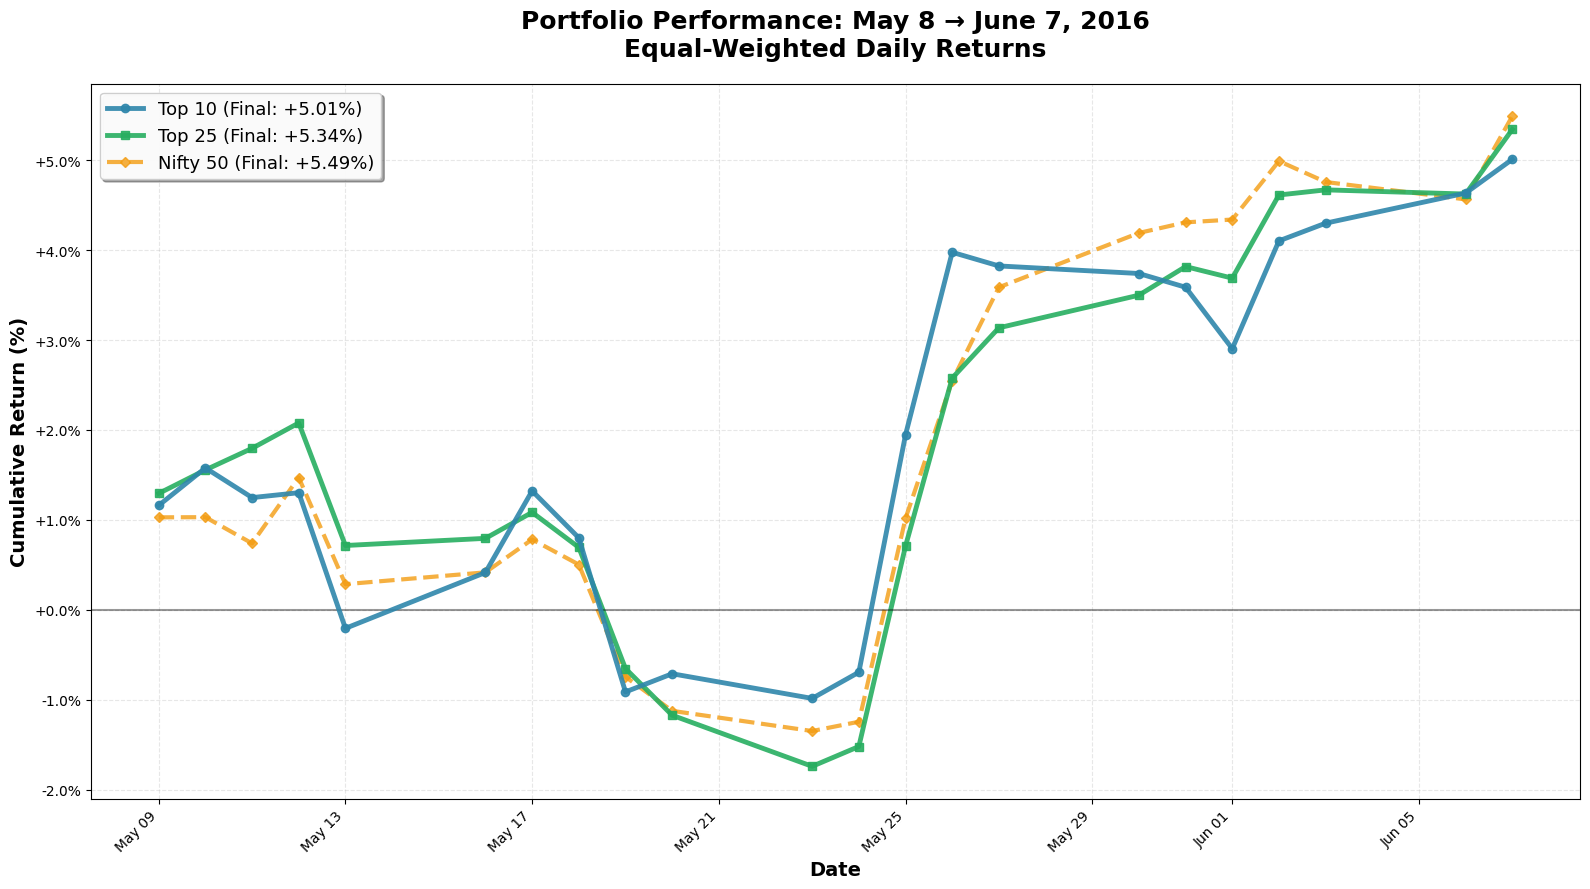

In [17]:
# Create daily progression chart using existing CSV files
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("="*100)
print("CREATING DAILY PROGRESSION CHART")
print("="*100)

# Load daily performance data
top10_daily = pd.read_csv('may8_jun7_top10_daily_performance.csv')
top25_daily = pd.read_csv('may8_jun7_top25_daily_performance.csv')
nifty50_daily = pd.read_csv('may8_jun7_nifty50_daily_performance.csv')

# Convert date columns
top10_daily['date'] = pd.to_datetime(top10_daily['date'])
top25_daily['date'] = pd.to_datetime(top25_daily['date'])
nifty50_daily['date'] = pd.to_datetime(nifty50_daily['date'])

# Create line chart
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(top10_daily['date'], top10_daily['avg_return'],
        label=f'Top 10 (Final: {top10_daily["avg_return"].iloc[-1]:+.2f}%)',
        color='#2E86AB', linewidth=3.5, marker='o', markersize=6, alpha=0.9, zorder=3)

ax.plot(top25_daily['date'], top25_daily['avg_return'],
        label=f'Top 25 (Final: {top25_daily["avg_return"].iloc[-1]:+.2f}%)',
        color='#27AE60', linewidth=3.5, marker='s', markersize=6, alpha=0.9, zorder=2)

ax.plot(nifty50_daily['date'], nifty50_daily['avg_return'],
        label=f'Nifty 50 (Final: {nifty50_daily["avg_return"].iloc[-1]:+.2f}%)',
        color='#F39C12', linewidth=3, marker='D', markersize=5, alpha=0.8, linestyle='--', zorder=1)

# Add zero line
ax.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.4)

# Styling
ax.set_title('Portfolio Performance: May 8 → June 7, 2016\nEqual-Weighted Daily Returns',
             fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Cumulative Return (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

ax.legend(loc='upper left', fontsize=13, framealpha=0.95, shadow=True)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:+.1f}%'))

plt.tight_layout()
plt.savefig('portfolio_daily_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: portfolio_daily_comparison.png")
plt.show()

TRACKING DAILY PERFORMANCE: TOP 10 vs TOP 25 vs NIFTY 50

✅ Loaded selections:
   Top 10: 10 stocks - VEDL, BHEL, M&M, TATAPOWER, GRASIM, HDFC, GAIL, AXISBANK, INDUSINDBK, YESBANK
   Top 25: 25 stocks
   Nifty 50: 50 stocks

   Tracking Period: 2016-05-08 to 2016-06-07
   Trading Days: 22

⏳ Calculating daily returns...

✅ Daily tracking complete:
   Top 10 Final Return:   +5.01%
   Top 25 Final Return:   +5.34%
   Nifty 50 Final Return: +5.49%

✅ Saved: daily_tracking_top10_top25_nifty50.csv

📊 Creating visualization...
✅ Saved: comprehensive_daily_tracking_comparison.png


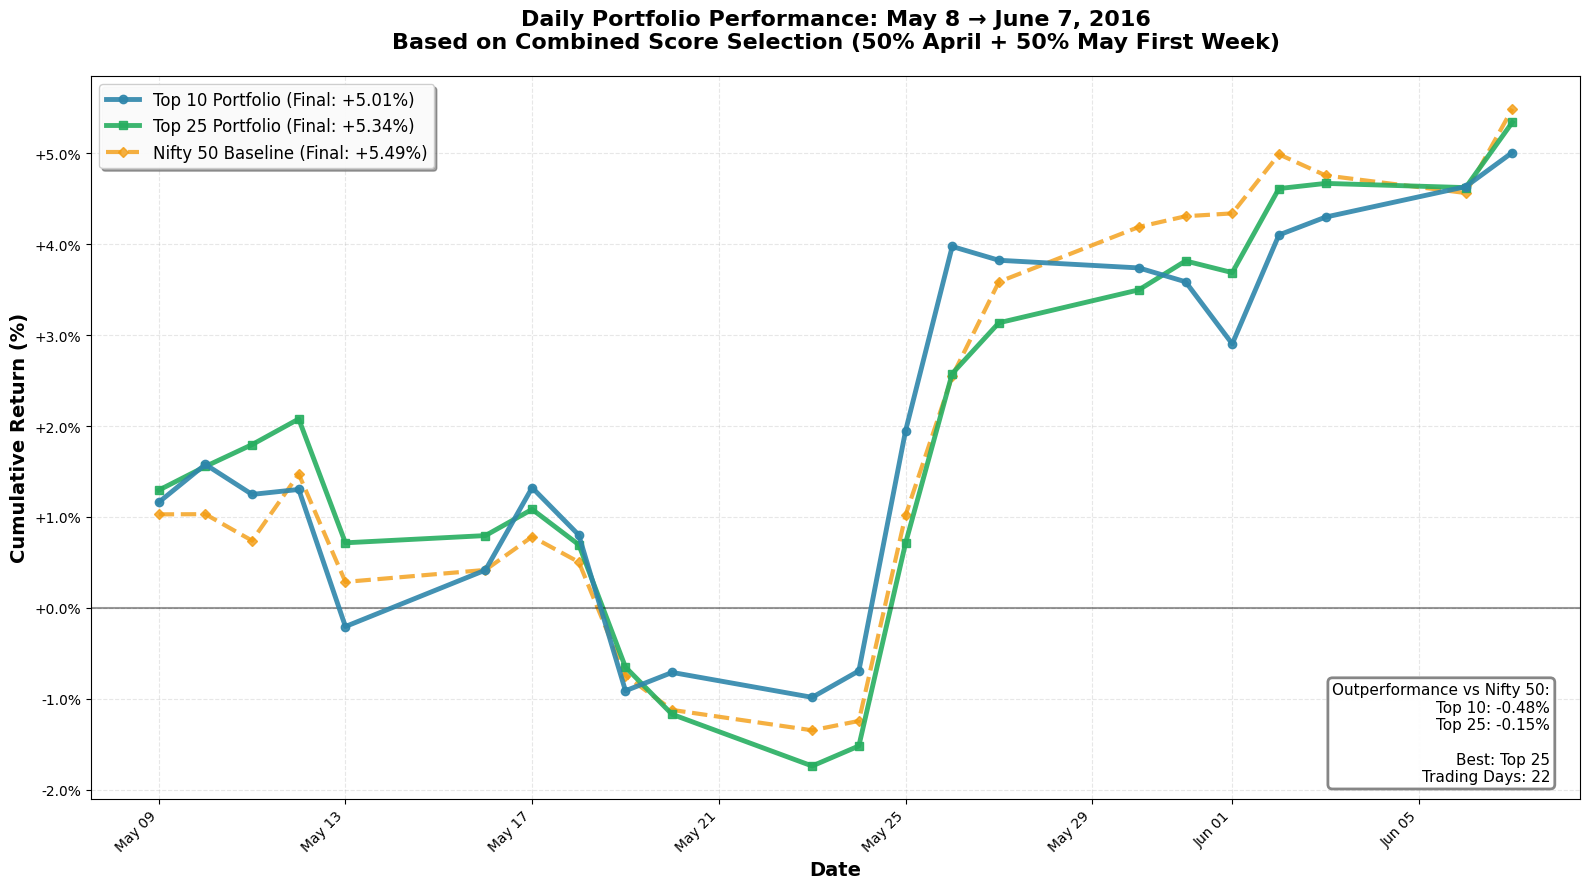


DAILY PERFORMANCE SUMMARY
      date  top10_return  top25_return  nifty50_return
2016-05-09      1.160920      1.294199        1.028496
2016-05-10      1.577874      1.555277        1.030359
2016-05-11      1.247979      1.795788        0.739114
2016-05-12      1.302388      2.077910        1.471345
2016-05-13     -0.205869      0.715344        0.285175
2016-05-16      0.415264      0.794911        0.416951
2016-05-17      1.322224      1.083826        0.782754
2016-05-18      0.800724      0.694558        0.503547
2016-05-19     -0.912774     -0.652739       -0.744827
2016-05-20     -0.710710     -1.172145       -1.123281
2016-05-23     -0.984923     -1.740215       -1.347621
2016-05-24     -0.693868     -1.519799       -1.244455
2016-05-25      1.945599      0.709420        1.017325
2016-05-26      3.975613      2.577166        2.547603
2016-05-27      3.824015      3.136014        3.586493
2016-05-30      3.739799      3.498792        4.190820
2016-05-31      3.587102      3.816842

In [18]:
# Track Daily Performance of Top 10 vs Top 25 vs Nifty 50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("="*100)
print("TRACKING DAILY PERFORMANCE: TOP 10 vs TOP 25 vs NIFTY 50")
print("="*100)

# 1. Load comprehensive CSV to get stock selections
comp_df = pd.read_csv('comprehensive_strategy_analysis_all_stocks.csv')

# Extract Top 10 and Top 25 stocks
top10_tickers = comp_df[comp_df['May_Selection'] == 'Top 10']['Ticker'].tolist()
top25_tickers = comp_df[comp_df['May_Selection'].isin(['Top 10', 'Top 25'])]['Ticker'].tolist()
all_tickers = comp_df['Ticker'].tolist()

print(f"\n✅ Loaded selections:")
print(f"   Top 10: {len(top10_tickers)} stocks - {', '.join(top10_tickers)}")
print(f"   Top 25: {len(top25_tickers)} stocks")
print(f"   Nifty 50: {len(all_tickers)} stocks")

# 2. Define tracking period
start_date = pd.Timestamp('2016-05-08')
end_date = pd.Timestamp('2016-06-07')

print(f"\n   Tracking Period: {start_date.date()} to {end_date.date()}")

# 3. Filter daily data for tracking period
tracking_data = daily_df[(daily_df['date'] >= start_date) & 
                         (daily_df['date'] <= end_date)].copy()

trading_days = sorted(tracking_data['date'].unique())
print(f"   Trading Days: {len(trading_days)}")

# 4. Function to calculate daily portfolio returns
def calculate_portfolio_daily_returns(tickers, data, trading_days):
    """Calculate equal-weighted daily returns for a portfolio"""
    portfolio_returns = []
    
    for day in trading_days:
        day_returns = []
        
        for ticker in tickers:
            # Get ticker data up to and including current day
            ticker_history = data[(data['ticker'] == ticker) & 
                                 (data['date'] <= day)].sort_values('date')
            
            if len(ticker_history) > 0:
                # First day open price
                start_price = ticker_history.iloc[0]['open']
                # Current day close price
                current_close = ticker_history[ticker_history['date'] == day]['close'].values
                
                if len(current_close) > 0:
                    ret = ((current_close[0] - start_price) / start_price) * 100
                    day_returns.append(ret)
        
        # Equal-weighted average
        if day_returns:
            portfolio_returns.append(np.mean(day_returns))
        else:
            portfolio_returns.append(np.nan)
    
    return portfolio_returns

# 5. Calculate daily returns for each portfolio
print("\n⏳ Calculating daily returns...")

top10_returns = calculate_portfolio_daily_returns(top10_tickers, tracking_data, trading_days)
top25_returns = calculate_portfolio_daily_returns(top25_tickers, tracking_data, trading_days)
nifty50_returns = calculate_portfolio_daily_returns(all_tickers, tracking_data, trading_days)

# 6. Create results DataFrame
results_df = pd.DataFrame({
    'date': trading_days,
    'top10_return': top10_returns,
    'top25_return': top25_returns,
    'nifty50_return': nifty50_returns
})

print(f"\n✅ Daily tracking complete:")
print(f"   Top 10 Final Return:   {top10_returns[-1]:+.2f}%")
print(f"   Top 25 Final Return:   {top25_returns[-1]:+.2f}%")
print(f"   Nifty 50 Final Return: {nifty50_returns[-1]:+.2f}%")

# 7. Save results
results_df.to_csv('daily_tracking_top10_top25_nifty50.csv', index=False)
print(f"\n✅ Saved: daily_tracking_top10_top25_nifty50.csv")

# 8. Create visualization
print("\n📊 Creating visualization...")

fig, ax = plt.subplots(figsize=(16, 9))

# Plot the three portfolios
ax.plot(results_df['date'], results_df['top10_return'], 
        label=f'Top 10 Portfolio (Final: {top10_returns[-1]:+.2f}%)', 
        color='#2E86AB', linewidth=3.5, marker='o', markersize=6, alpha=0.9, zorder=3)

ax.plot(results_df['date'], results_df['top25_return'], 
        label=f'Top 25 Portfolio (Final: {top25_returns[-1]:+.2f}%)', 
        color='#27AE60', linewidth=3.5, marker='s', markersize=6, alpha=0.9, zorder=2)

ax.plot(results_df['date'], results_df['nifty50_return'], 
        label=f'Nifty 50 Baseline (Final: {nifty50_returns[-1]:+.2f}%)', 
        color='#F39C12', linewidth=3, marker='D', markersize=5, alpha=0.8, linestyle='--', zorder=1)

# Add zero line
ax.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.4)

# Styling
ax.set_title('Daily Portfolio Performance: May 8 → June 7, 2016\nBased on Combined Score Selection (50% April + 50% May First Week)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Cumulative Return (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.95, shadow=True)

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:+.1f}%'))

# Add statistics box
outperformance_10 = top10_returns[-1] - nifty50_returns[-1]
outperformance_25 = top25_returns[-1] - nifty50_returns[-1]

stats_text = (f'Outperformance vs Nifty 50:\n'
              f'Top 10: {outperformance_10:+.2f}%\n'
              f'Top 25: {outperformance_25:+.2f}%\n'
              f'\n'
              f'Best: {"Top 10" if top10_returns[-1] > top25_returns[-1] else "Top 25"}\n'
              f'Trading Days: {len(trading_days)}')

ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                 edgecolor='gray', linewidth=2))

plt.tight_layout()
plt.savefig('comprehensive_daily_tracking_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: comprehensive_daily_tracking_comparison.png")
plt.show()

# 9. Print summary table
print("\n" + "="*100)
print("DAILY PERFORMANCE SUMMARY")
print("="*100)
print(results_df.to_string(index=False))

print("\n" + "="*100)
print("✅ TRACKING COMPLETE")
print("="*100)

CREATING INDIVIDUAL STOCK CHARTS - TOP 10 & TOP 25

✅ Top 10 Stocks (10): VEDL, BHEL, M&M, TATAPOWER, GRASIM, HDFC, GAIL, AXISBANK, INDUSINDBK, YESBANK
✅ Top 25 Stocks (25): 25 total

   Tracking Period: 2016-05-08 to 2016-06-07
   Trading Days: 22

📊 Creating Top 10 Individual Stocks Chart...
✅ Saved: top10_individual_daily_tracking.png


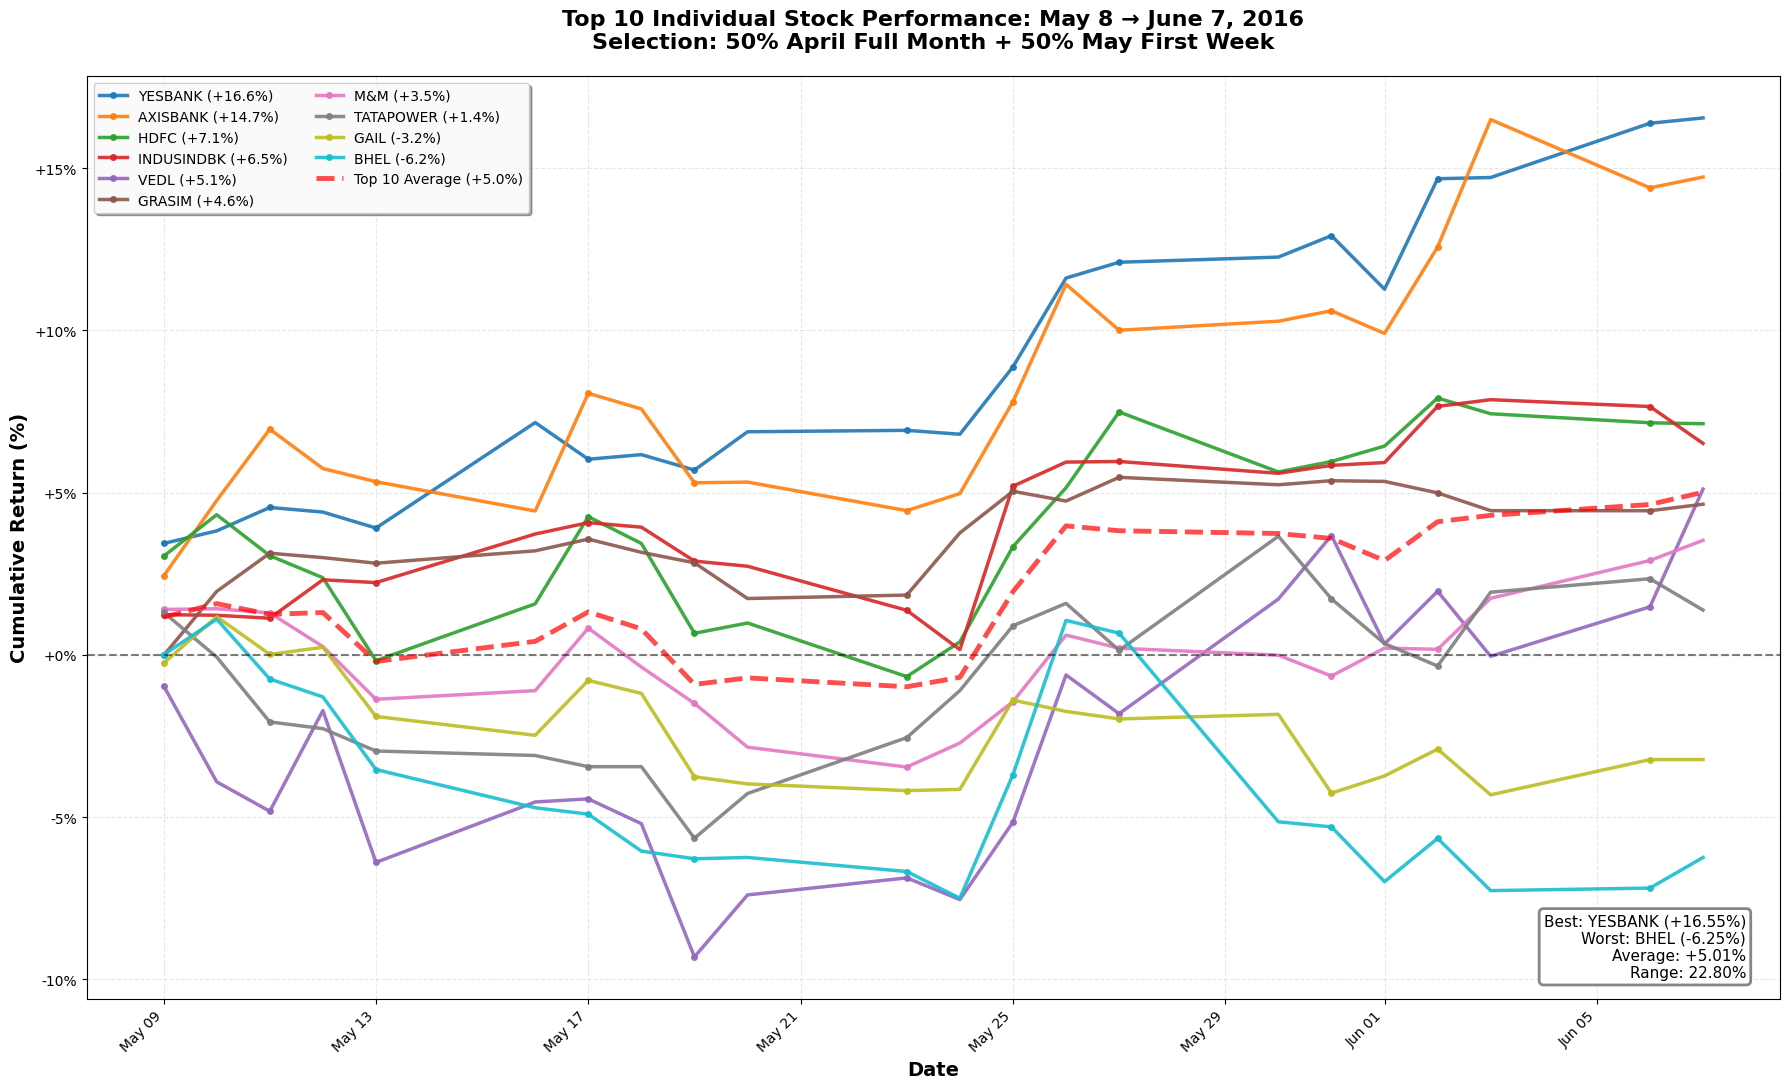

✅ Saved: top10_individual_daily_data.csv

📊 Creating Top 25 Individual Stocks Chart...
✅ Saved: top25_individual_daily_tracking.png


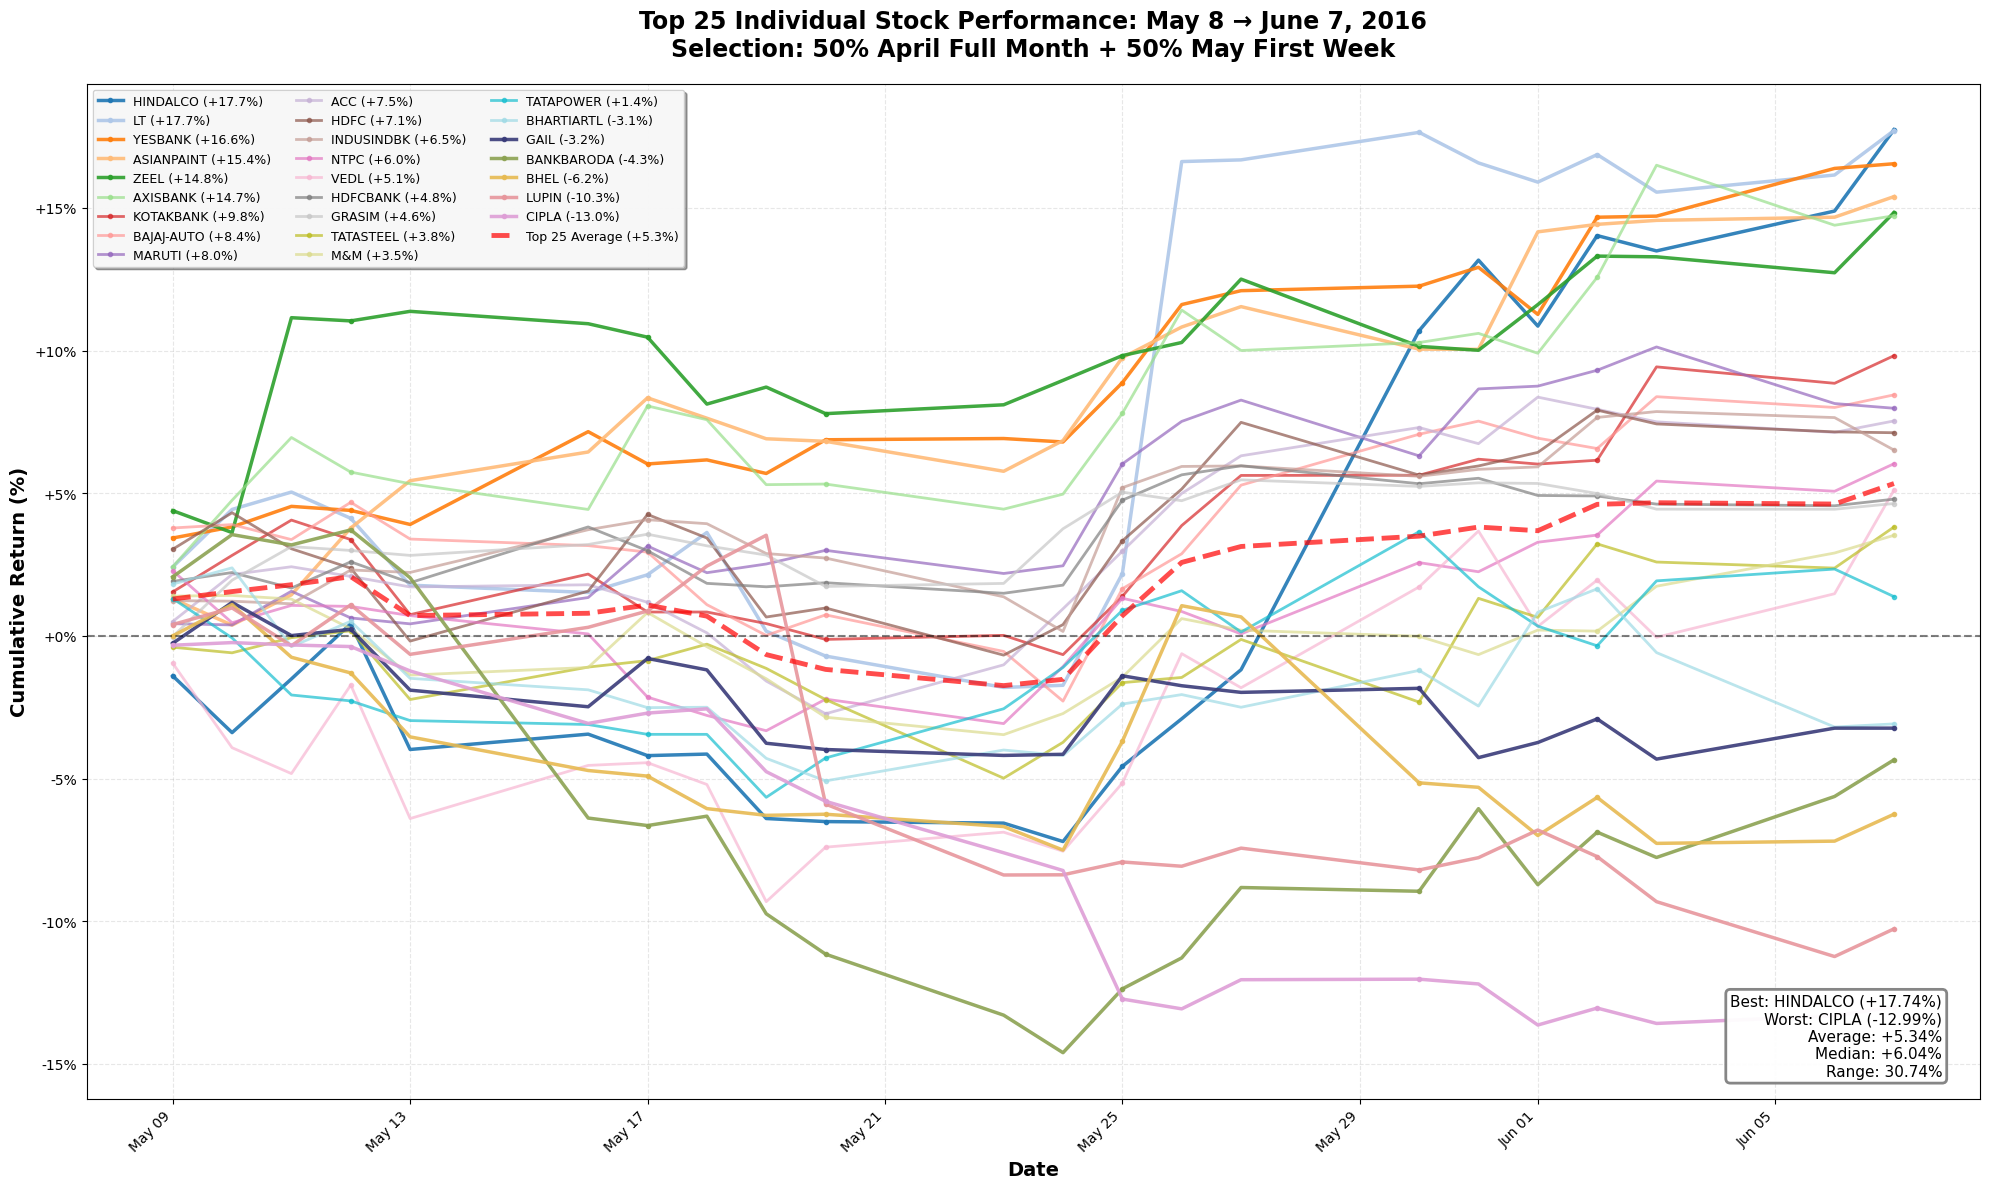

✅ Saved: top25_individual_daily_data.csv

SUMMARY

TOP 10 PORTFOLIO:
  Average Return: +5.01%
  Best: YESBANK (+16.55%)
  Worst: BHEL (-6.25%)

TOP 25 PORTFOLIO:
  Average Return: +5.34%
  Best: HINDALCO (+17.74%)
  Worst: CIPLA (-12.99%)

📁 FILES CREATED:
  - top10_individual_daily_tracking.png
  - top10_individual_daily_data.csv
  - top25_individual_daily_tracking.png
  - top25_individual_daily_data.csv

✅ COMPLETE


In [19]:
# INDIVIDUAL STOCK TRACKING: TOP 10 & TOP 25 SEPARATE CHARTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("="*100)
print("CREATING INDIVIDUAL STOCK CHARTS - TOP 10 & TOP 25")
print("="*100)

# 1. Load comprehensive CSV to get stock selections
comp_df = pd.read_csv('comprehensive_strategy_analysis_all_stocks.csv')

# Extract Top 10 and Top 25 stocks
top10_tickers = comp_df[comp_df['May_Selection'] == 'Top 10']['Ticker'].tolist()
top25_tickers = comp_df[comp_df['May_Selection'].isin(['Top 10', 'Top 25'])]['Ticker'].tolist()

print(f"\n✅ Top 10 Stocks ({len(top10_tickers)}): {', '.join(top10_tickers)}")
print(f"✅ Top 25 Stocks ({len(top25_tickers)}): {len(top25_tickers)} total")

# 2. Define tracking period (May 8 to June 7 based on your strategy)
start_date = pd.Timestamp('2016-05-08')
end_date = pd.Timestamp('2016-06-07')

print(f"\n   Tracking Period: {start_date.date()} to {end_date.date()}")

# Filter data
tracking_data = daily_df[(daily_df['date'] >= start_date) & 
                         (daily_df['date'] <= end_date)].copy()
trading_days = sorted(tracking_data['date'].unique())
print(f"   Trading Days: {len(trading_days)}")

# 3. Function to calculate individual stock returns
def get_individual_stock_returns(ticker, data, trading_days):
    """Calculate daily cumulative returns for a single stock"""
    ticker_data = data[data['ticker'] == ticker].sort_values('date')
    
    if len(ticker_data) == 0:
        return [np.nan] * len(trading_days)
    
    # Get start price (open on first day)
    start_price = ticker_data.iloc[0]['open']
    
    daily_returns = []
    for day in trading_days:
        day_data = ticker_data[ticker_data['date'] == day]
        if len(day_data) > 0:
            close_price = day_data.iloc[0]['close']
            ret = ((close_price - start_price) / start_price) * 100
            daily_returns.append(ret)
        else:
            # Use last available return if no data for this day
            daily_returns.append(daily_returns[-1] if daily_returns else 0)
    
    return daily_returns

# ============================================================================
# CHART 1: TOP 10 INDIVIDUAL STOCKS
# ============================================================================
print("\n📊 Creating Top 10 Individual Stocks Chart...")

# Calculate returns for each Top 10 stock
top10_data = {'date': trading_days}
final_returns_top10 = {}

for ticker in top10_tickers:
    returns = get_individual_stock_returns(ticker, tracking_data, trading_days)
    top10_data[ticker] = returns
    final_returns_top10[ticker] = returns[-1]

# Sort stocks by final return
sorted_top10 = sorted(final_returns_top10.keys(), key=lambda x: final_returns_top10[x], reverse=True)

# Create chart
fig, ax = plt.subplots(figsize=(18, 11))

# Define colors
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot each stock
for i, ticker in enumerate(sorted_top10):
    final_ret = final_returns_top10[ticker]
    
    ax.plot(trading_days, top10_data[ticker], 
            label=f'{ticker} ({final_ret:+.1f}%)', 
            color=colors[i], 
            linewidth=2.5, 
            marker='o', 
            markersize=4, 
            alpha=0.9,
            markevery=2)

# Add zero line
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Calculate average
avg_return = np.mean([top10_data[t][-1] for t in top10_tickers])
ax.plot(trading_days, [np.mean([top10_data[t][i] for t in top10_tickers]) for i in range(len(trading_days))],
        label=f'Top 10 Average ({avg_return:+.1f}%)',
        color='red', linewidth=3.5, linestyle='--', alpha=0.7, zorder=5)

# Styling
ax.set_title('Top 10 Individual Stock Performance: May 8 → June 7, 2016\nSelection: 50% April Full Month + 50% May First Week', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Cumulative Return (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Legend (sorted by final return)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, shadow=True, ncol=2)

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:+.0f}%'))

# Add summary statistics
best_stock = sorted_top10[0]
worst_stock = sorted_top10[-1]

stats_text = (f'Best: {best_stock} ({final_returns_top10[best_stock]:+.2f}%)\n'
              f'Worst: {worst_stock} ({final_returns_top10[worst_stock]:+.2f}%)\n'
              f'Average: {avg_return:+.2f}%\n'
              f'Range: {final_returns_top10[best_stock] - final_returns_top10[worst_stock]:.2f}%')

ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                 edgecolor='gray', linewidth=2))

plt.tight_layout()
plt.savefig('top10_individual_daily_tracking.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: top10_individual_daily_tracking.png")
plt.show()

# Save Top 10 data to CSV
top10_df = pd.DataFrame(top10_data)
top10_df.to_csv('top10_individual_daily_data.csv', index=False)
print("✅ Saved: top10_individual_daily_data.csv")

# ============================================================================
# CHART 2: TOP 25 INDIVIDUAL STOCKS
# ============================================================================
print("\n📊 Creating Top 25 Individual Stocks Chart...")

# Calculate returns for each Top 25 stock
top25_data = {'date': trading_days}
final_returns_top25 = {}

for ticker in top25_tickers:
    returns = get_individual_stock_returns(ticker, tracking_data, trading_days)
    top25_data[ticker] = returns
    final_returns_top25[ticker] = returns[-1]

# Sort stocks by final return
sorted_top25 = sorted(final_returns_top25.keys(), key=lambda x: final_returns_top25[x], reverse=True)

# Create chart
fig, ax = plt.subplots(figsize=(20, 12))

# Define colors (mix of palettes for 25 stocks)
colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, 5))
colors = np.vstack([colors1, colors2])

# Plot each stock
for i, ticker in enumerate(sorted_top25):
    final_ret = final_returns_top25[ticker]
    
    # Thicker lines for top 5 and bottom 5
    if i < 5 or i >= 20:
        linewidth = 2.5
        alpha = 0.9
    else:
        linewidth = 2.0
        alpha = 0.7
    
    ax.plot(trading_days, top25_data[ticker], 
            label=f'{ticker} ({final_ret:+.1f}%)', 
            color=colors[i], 
            linewidth=linewidth, 
            marker='o', 
            markersize=3, 
            alpha=alpha,
            markevery=3)

# Add zero line
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Calculate average
avg_return = np.mean([top25_data[t][-1] for t in top25_tickers])
ax.plot(trading_days, [np.mean([top25_data[t][i] for t in top25_tickers]) for i in range(len(trading_days))],
        label=f'Top 25 Average ({avg_return:+.1f}%)',
        color='red', linewidth=3.5, linestyle='--', alpha=0.7, zorder=5)

# Styling
ax.set_title('Top 25 Individual Stock Performance: May 8 → June 7, 2016\nSelection: 50% April Full Month + 50% May First Week', 
             fontsize=17, fontweight='bold', pad=20)
ax.set_ylabel('Cumulative Return (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Legend (sorted by final return, 3 columns)
ax.legend(loc='upper left', fontsize=9, framealpha=0.92, shadow=True, ncol=3)

# X-axis formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45, ha='right')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:+.0f}%'))

# Add summary statistics
best_stock = sorted_top25[0]
worst_stock = sorted_top25[-1]
median_return = np.median([final_returns_top25[t] for t in sorted_top25])

stats_text = (f'Best: {best_stock} ({final_returns_top25[best_stock]:+.2f}%)\n'
              f'Worst: {worst_stock} ({final_returns_top25[worst_stock]:+.2f}%)\n'
              f'Average: {avg_return:+.2f}%\n'
              f'Median: {median_return:+.2f}%\n'
              f'Range: {final_returns_top25[best_stock] - final_returns_top25[worst_stock]:.2f}%')

ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                 edgecolor='gray', linewidth=2))

plt.tight_layout()
plt.savefig('top25_individual_daily_tracking.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: top25_individual_daily_tracking.png")
plt.show()

# Save Top 25 data to CSV
top25_df = pd.DataFrame(top25_data)
top25_df.to_csv('top25_individual_daily_data.csv', index=False)
print("✅ Saved: top25_individual_daily_data.csv")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*100)
print("SUMMARY")
print("="*100)
print(f"\nTOP 10 PORTFOLIO:")
print(f"  Average Return: {np.mean([final_returns_top10[t] for t in top10_tickers]):+.2f}%")
print(f"  Best: {sorted_top10[0]} ({final_returns_top10[sorted_top10[0]]:+.2f}%)")
print(f"  Worst: {sorted_top10[-1]} ({final_returns_top10[sorted_top10[-1]]:+.2f}%)")

print(f"\nTOP 25 PORTFOLIO:")
print(f"  Average Return: {np.mean([final_returns_top25[t] for t in top25_tickers]):+.2f}%")
print(f"  Best: {sorted_top25[0]} ({final_returns_top25[sorted_top25[0]]:+.2f}%)")
print(f"  Worst: {sorted_top25[-1]} ({final_returns_top25[sorted_top25[-1]]:+.2f}%)")

print("\n📁 FILES CREATED:")
print("  - top10_individual_daily_tracking.png")
print("  - top10_individual_daily_data.csv")
print("  - top25_individual_daily_tracking.png")
print("  - top25_individual_daily_data.csv")

print("\n" + "="*100)
print("✅ COMPLETE")
print("="*100)

Combined score Graph


CREATING COMBINED SCORE BAR CHART

✅ Loaded 50 stocks
   Highest Score: VEDL (6.90)
   Lowest Score: ADANIPORTS (-10.93)

✅ Saved: combined_scores_bar_chart_descending.png


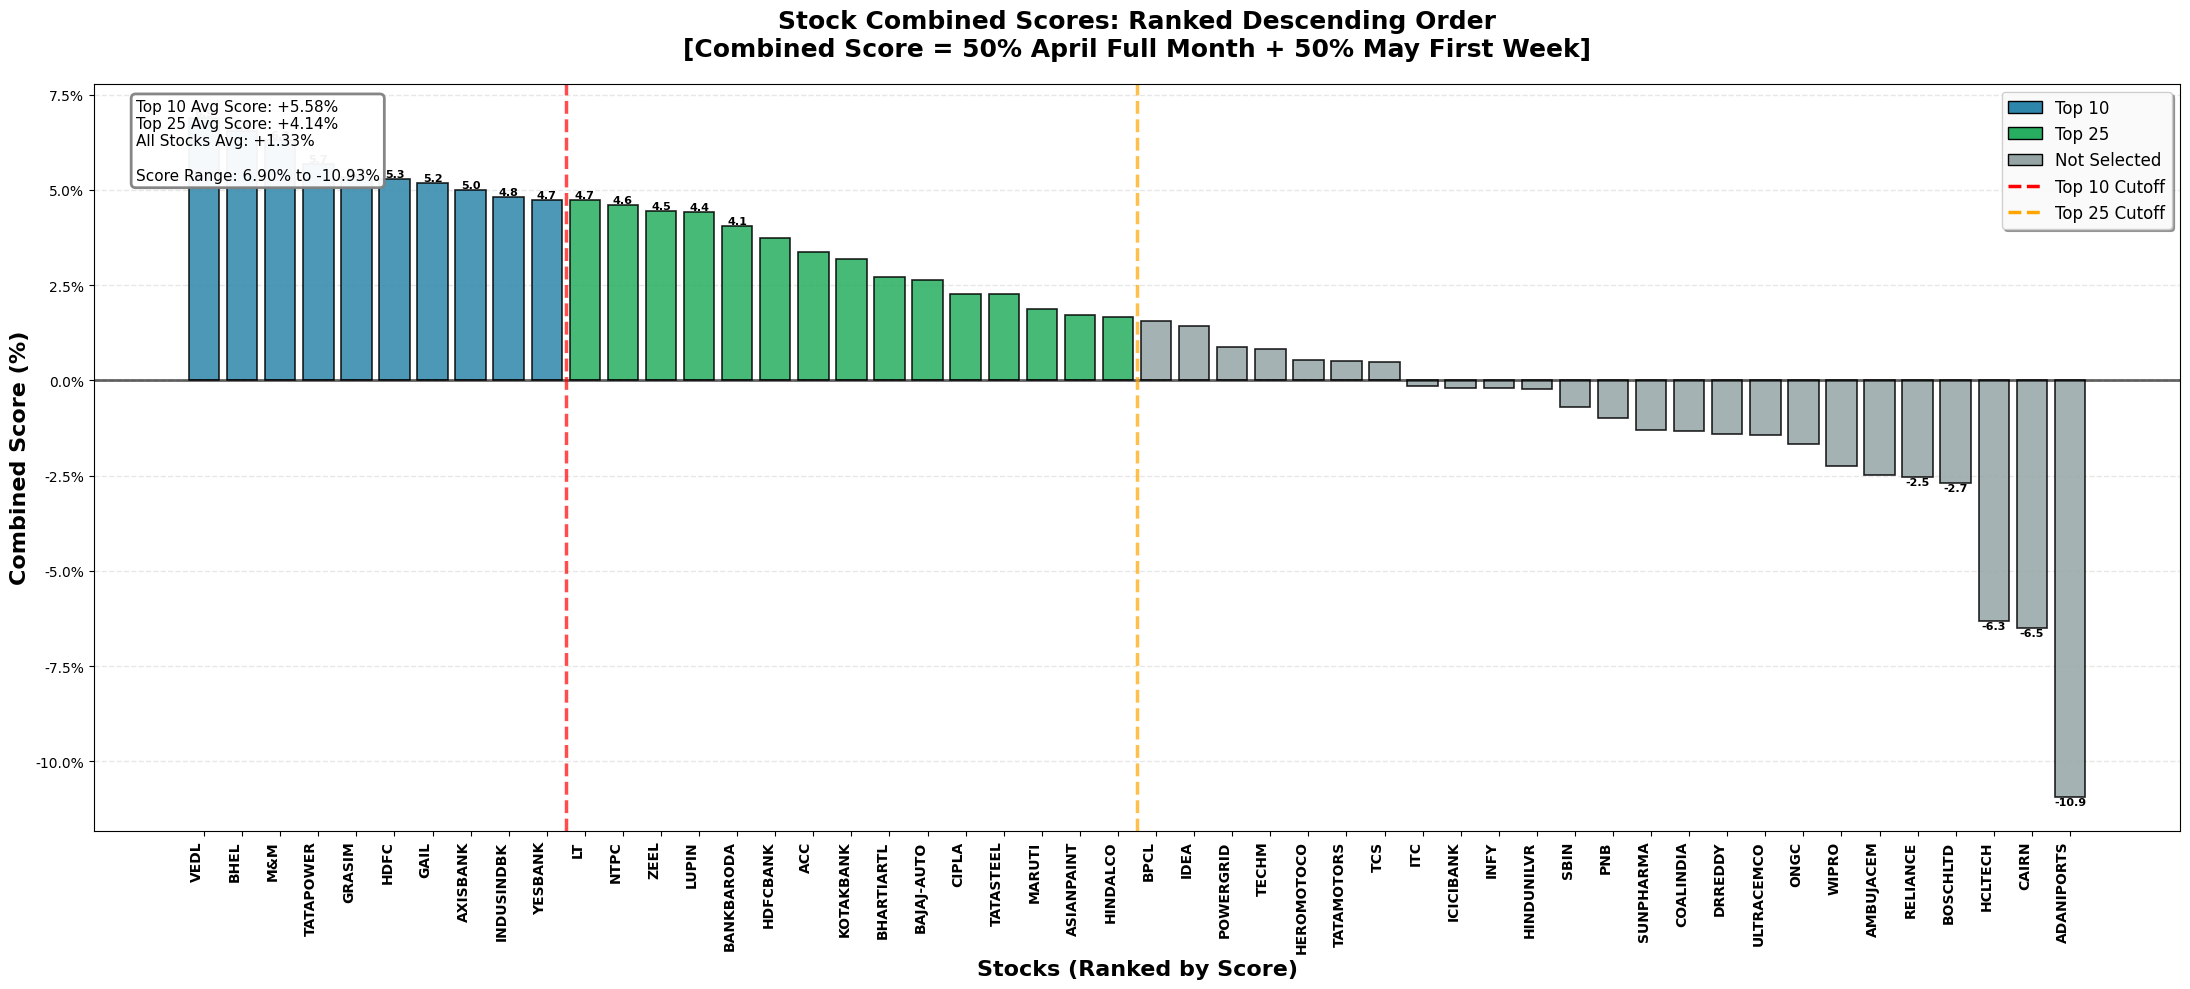


TOP 10 STOCKS BY COMBINED SCORE
    Ticker  May_Combined_Score May_Selection
      VEDL            6.900469        Top 10
      BHEL            6.556661        Top 10
       M&M            6.319680        Top 10
 TATAPOWER            5.691964        Top 10
    GRASIM            5.345424        Top 10
      HDFC            5.297530        Top 10
      GAIL            5.178609        Top 10
  AXISBANK            5.005779        Top 10
INDUSINDBK            4.812680        Top 10
   YESBANK            4.729681        Top 10

BOTTOM 10 STOCKS BY COMBINED SCORE
    Ticker  May_Combined_Score May_Selection
   DRREDDY           -1.405770  Not Selected
ULTRACEMCO           -1.423822  Not Selected
      ONGC           -1.675488  Not Selected
     WIPRO           -2.236210  Not Selected
 AMBUJACEM           -2.497176  Not Selected
  RELIANCE           -2.532580  Not Selected
  BOSCHLTD           -2.693924  Not Selected
   HCLTECH           -6.330000  Not Selected
     CAIRN           -6.508649 

In [20]:
# BAR GRAPH: COMBINED SCORES - DESCENDING ORDER
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("="*100)
print("CREATING COMBINED SCORE BAR CHART")
print("="*100)

# Load comprehensive CSV
comp_df = pd.read_csv('comprehensive_strategy_analysis_all_stocks.csv')

# Sort by Combined Score (descending)
comp_df_sorted = comp_df.sort_values('May_Combined_Score', ascending=False).reset_index(drop=True)

print(f"\n✅ Loaded {len(comp_df_sorted)} stocks")
print(f"   Highest Score: {comp_df_sorted.iloc[0]['Ticker']} ({comp_df_sorted.iloc[0]['May_Combined_Score']:.2f})")
print(f"   Lowest Score: {comp_df_sorted.iloc[-1]['Ticker']} ({comp_df_sorted.iloc[-1]['May_Combined_Score']:.2f})")

# Create color mapping based on selection
def get_bar_color(selection):
    if selection == 'Top 10':
        return '#2E86AB'  # Blue
    elif selection == 'Top 25':
        return '#27AE60'  # Green
    else:
        return '#95A5A6'  # Gray

colors = [get_bar_color(sel) for sel in comp_df_sorted['May_Selection']]

# Create bar chart
fig, ax = plt.subplots(figsize=(22, 10))

bars = ax.bar(range(len(comp_df_sorted)), 
              comp_df_sorted['May_Combined_Score'], 
              color=colors, 
              edgecolor='black', 
              linewidth=1.2, 
              alpha=0.85)

# Add value labels on top of bars (only for top 15 and bottom 5)
for i, (idx, row) in enumerate(comp_df_sorted.iterrows()):
    if i < 15 or i >= len(comp_df_sorted) - 5:
        height = row['May_Combined_Score']
        ax.text(i, height, f'{height:.1f}', 
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=8, fontweight='bold')

# Add zero line
ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.6)

# Highlight Top 10 and Top 25 boundaries
ax.axvline(9.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7, label='Top 10 Cutoff')
ax.axvline(24.5, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, label='Top 25 Cutoff')

# Styling
ax.set_title('Stock Combined Scores: Ranked Descending Order\n[Combined Score = 50% April Full Month + 50% May First Week]', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Combined Score (%)', fontsize=16, fontweight='bold')
ax.set_xlabel('Stocks (Ranked by Score)', fontsize=16, fontweight='bold')

# X-axis: Stock tickers
ax.set_xticks(range(len(comp_df_sorted)))
ax.set_xticklabels(comp_df_sorted['Ticker'], rotation=90, ha='right', fontsize=10, fontweight='bold')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# Grid
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

# Legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='Top 10'),
    Patch(facecolor='#27AE60', edgecolor='black', label='Top 25'),
    Patch(facecolor='#95A5A6', edgecolor='black', label='Not Selected'),
    plt.Line2D([0], [0], color='red', linewidth=2.5, linestyle='--', label='Top 10 Cutoff'),
    plt.Line2D([0], [0], color='orange', linewidth=2.5, linestyle='--', label='Top 25 Cutoff')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.95, shadow=True)

# Add statistics box
top10_avg = comp_df_sorted.head(10)['May_Combined_Score'].mean()
top25_avg = comp_df_sorted.head(25)['May_Combined_Score'].mean()
all_avg = comp_df_sorted['May_Combined_Score'].mean()

stats_text = (f'Top 10 Avg Score: {top10_avg:+.2f}%\n'
              f'Top 25 Avg Score: {top25_avg:+.2f}%\n'
              f'All Stocks Avg: {all_avg:+.2f}%\n'
              f'\n'
              f'Score Range: {comp_df_sorted["May_Combined_Score"].max():.2f}% to {comp_df_sorted["May_Combined_Score"].min():.2f}%')

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                 edgecolor='gray', linewidth=2))

plt.tight_layout()
plt.savefig('combined_scores_bar_chart_descending.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Saved: combined_scores_bar_chart_descending.png")
plt.show()

# Print Top 10 and Bottom 10
print("\n" + "="*100)
print("TOP 10 STOCKS BY COMBINED SCORE")
print("="*100)
print(comp_df_sorted.head(10)[['Ticker', 'May_Combined_Score', 'May_Selection']].to_string(index=False))

print("\n" + "="*100)
print("BOTTOM 10 STOCKS BY COMBINED SCORE")
print("="*100)
print(comp_df_sorted.tail(10)[['Ticker', 'May_Combined_Score', 'May_Selection']].to_string(index=False))

print("\n" + "="*100)
print("✅ COMPLETE")
print("="*100)